# Kaggle Competition: Santander Customer Satisfaction

Contents (not final arrangement)
1. Abstract
2. Introduction
3. Data and Data Cleanup
    - .describe()
    - no variance columns
    - duplicates
    - errors
4. Features
    - imp_ent_varX
    - imp_op_varX
    - ind_varX
    - num_varX
    - saldo_varX
    - delta
    - varX
    - creating features
5. Feature Selection
6. Modeling
7. Concluding Thoughts

## 1. Abstract
In this Kaggle.com Competition, given the train and test datasets provided by Santander Bank, predict which of its customers, those that are represented in the test data, are unhappy with their experience based on what can be gleaned from the train data.

## 2. Introduction
From the competition page:
> From frontline support teams to C-suites, customer satisfaction is a key measure of success. Unhappy customers don't stick around. What's more, unhappy customers rarely voice their dissatisfaction before leaving.

> Santander Bank is asking Kagglers to help them identify dissatisfied customers early in their relationship. Doing so would allow Santander to take proactive steps to improve a customer's happiness before it's too late.

> In this competition, you'll work with hundreds of anonymized features to predict if a customer is satisfied or dissatisfied with their banking experience.

Santander provides the data for competiting participants in two .csv files, plus an additional file to show how they expect the data to be submitted. Not having to dig for the data ourselves seems lovely, but there is a caveat here: **Santander provides no context, no data dictionary or code book, to accompany the data.** Participants have only the feature names and the data itself--and, to some degree, other participants despite this being a competition--to work with.

## 3. Data and Data Cleanup
The files provided are '**train.csv**' and '**test.csv**' (with a third file, sample_submission.csv, to demonstrate in what format submitted predictions are required to be). The file 'train.csv' is for training the participant's model while 'test.csv' is what the participant has to test their models and predict responses accordingly.

(By the way, you should **extract train.csv.zip and test.csv.zip** into whatever folder this .ipynb is in.)

(Another by the way, the original train.csv and test.csv files began with 'ID' without an apostrophe, which made my Microsoft Excel complain because apparently a text file starting with 'ID' is the format of another file format, if there's an apostrophe before 'ID' it's there to keep Excel from complaining. This is fine up until submitting predictions to the competition, as the competition page expects no apostrophe there.)

In [2]:
# import all the things
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

In [3]:
santrainder = pd.read_csv('train.csv')
santestder = pd.read_csv('test.csv')
print santrainder.shape
print santestder.shape

(76020, 371)
(75818, 370)


In [4]:
santrainder.TARGET.value_counts()

0    73012
1     3008
Name: TARGET, dtype: int64

Both **train.csv** and **test.csv** are about the same size and shape, with **train.csv** having 76,020 observations and **test.csv** having 75,818. There are 370 features to sift through, and the additional 371st column in train.csv being the response vector 'TARGET'.

For this project we focus mostly on **train.csv** as the file is what we use to train our model, but understandably the two datasets are fairly similar at a glance, with the key difference of **test.csv** not having a **response vector** (test.csv's response vector is what participants have to predict and submit for the competition).

In TARGET, **0's represent happy campers and 1's are the customers who left the bank**. In train.csv there are **3,008 1's**, which is about 4% of the 76,020 grand total customer observations in the file.

Now, looking at the features:

In [5]:
print santrainder.columns

Index([u''ID', u'var3', u'var15', u'imp_ent_var16_ult1',
       u'imp_op_var39_comer_ult1', u'imp_op_var39_comer_ult3',
       u'imp_op_var40_comer_ult1', u'imp_op_var40_comer_ult3',
       u'imp_op_var40_efect_ult1', u'imp_op_var40_efect_ult3',
       ...
       u'saldo_medio_var33_hace2', u'saldo_medio_var33_hace3',
       u'saldo_medio_var33_ult1', u'saldo_medio_var33_ult3',
       u'saldo_medio_var44_hace2', u'saldo_medio_var44_hace3',
       u'saldo_medio_var44_ult1', u'saldo_medio_var44_ult3', u'var38',
       u'TARGET'],
      dtype='object', length=371)


... We can see that it's not in English. Santander Bank is a Spanish banking entity, one the largest banks in the eurozone, and so these features are in Spanish (*abbreviated* Spanish, no less). After some competition forum scouring and translation work, we have the following translation paradigm:

- imp_ent_varX => importe entidad => amount for the bank office
- imp_op_varX_comer => importe opcion comercial => amount for commercial option
- imp_sal_varX => importe salario => amount for wage
- ind_varX_corto => indicador corto => short (time lapse?) indicator/dummy
- ind_varX_medio => indicador medio => medium-sized (time lapse?) indicator/dummy
- ind_varX_largo => indicador largo => long-sized (time lapse?) indicator/dummy
- saldo_varX => saldo => balance
- delta_imp_amort_varX_1y3 => importe amortización 1 y 3 => amount/price for redemption (?) 1 and 3
- delta_imp_aport_varX_1y3 => importe aportación 1 y 3 => amount/price for contribution (?) 1 and 3
- delta_imp_reemb_varX_1y3 => importe reembolso 1 y 3 => amount/price for refund 1 and 3
- delta_imp_trasp_varX_out_1y3 => importe traspaso 1 y 3 => amount/price for transfer 1 and 3
- imp_venta_varX => importe venta => sale fee.
- ind_varX_emit_ult1 => indicador emitido => indicator of emission
- ind_varX_recib_ult1 => indicador recibido => indicator of reception
- num_varX_hace2 => número hace 2 => number [of variable X ] done two units in the past
- num_med_varX => número medio => mean number [of variable X]
- num_meses_varX => número de meses => number of months [for variable X]
- saldo_medio_varX => saldo medio => average balance
- delta_imp_venta_varX_1y3 = > importe de venta 1 y 3 => fee on sales [for variable X] 1 and 3

In [6]:
santrainder_en = pd.read_csv('train_english.csv')

In [7]:
print santrainder_en.columns

Index([u''ID', u'var3', u'var15', u'var16 entity amount last',
       u'var39 commercial option amount ultima1',
       u'var39 commercial option amount ultima3',
       u'var40 commercial option amount ultima1',
       u'var40 commercial option amount ultima3',
       u'var40 amount effective option ultima1',
       u'var40 amount effective option ultima3',
       ...
       u'var33 average balance hace2', u'var33 average balance hace3',
       u'var33 average balance ultima1', u'var33 average balance ultima3',
       u'var44 average balance hace2', u'var44 average balance hace3',
       u'var44 average balance ultima1', u'var44 average balance ultima3',
       u'var38', u'TARGET'],
      dtype='object', length=371)


This does help a little but not for the majority of features. There aren't really any hints as to what different '**varX**' mean (X being any positive integer between 3 and 46) right off the bat, but when looking at the data itself it's easy enough to tell from a glance which features are **categorical or numerical** (for the most part, anyway), and it is possible to guess the nature of certain features/variables by looking at their respective **histogram**, basic **.describe()** stats (**mean, median, mode, etc.**), and/or other measures.

But even without translation, it's clear there are contextually **different types of features**, which will be scrutinized further in the next section.

For visual simplicity's sake, when we're looking at data we'll be using the original abbreviated Spanish data, but when it comes to context we'll use English (noting its original Spanish when needed for clarity and vice versa).

### .describe()
A quick look at each feature's 'describes' can provide a good amount of detail. Because I find it easier to scroll through a bunch of data like that in a spreadsheet, I exported the dataframe's .describe() as a .csv file, having transposed it so that its shape would be 371x9 instead of 9x371, and scrolled through that in Microsoft Excel.

In [8]:
sandescriber = santrainder.describe().transpose()
sandescriber.to_csv(path_or_buf="train_describe.csv")

In [9]:
sandescriber.head()

,count,mean,std,min,25%,50%,75%,max
'ID,76020.0,75964.050723,43781.947379,1.0,38104.75,76043.0,113748.75,151838.00
var3,76020.0,-1523.199277,39033.462364,-999999.0,2.00,2.0,2.00,238.00
var15,76020.0,33.212865,12.956486,5.0,23.00,28.0,40.00,105.00
imp_ent_var16_ult1,76020.0,86.208265,1614.757313,0.0,0.00,0.0,0.00,210000.00
imp_op_var39_comer_ult1,76020.0,72.363067,339.315831,0.0,0.00,0.0,0.00,12888.03


### no variance columns
But data exploration in .ipynb is doable. The following is code I used to determine which features are most definitely useless:

In [10]:
all_zero_feats = []

# look for matching mins and maxes
for index, row in sandescriber.iterrows():
   if sandescriber.loc[index,'min'] == sandescriber.loc[index,'max']:
    all_zero_feats.append(index)

sandescriber.loc[all_zero_feats,:]

,count,mean,std,min,25%,50%,75%,max
ind_var2_0,76020.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ind_var2,76020.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ind_var27_0,76020.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ind_var28_0,76020.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ind_var28,76020.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ind_var27,76020.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ind_var41,76020.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ind_var46_0,76020.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ind_var46,76020.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
num_var27_0,76020.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can see that there is a good chunk of data that obviously does nothing for prediction. If the minimum and maximum are the same (thus giving us all-zero .describe()'s or similar), that means there isn't a range of data at all for those features. No variation, no effect on prediction. We can remove these safely before we start looking at features in depth.

I mean, it's entirely possible that these columns are supposed to work in tandem with other columns but what's the effect of adding zero to anything anyway?

Anyway, our number of features now drop from 371 to 337.

In [11]:
santrainder.drop(all_zero_feats, axis=1, inplace=True)
santrainder.head()

,'ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979,0


### duplicates
The internet is a magical place where people share their techniques for doing stuff. Finding duplicate columns is one of those things. It's not cheeeeating. Someone else just had a [more memory efficient alternative](http://stackoverflow.com/questions/14984119/python-pandas-remove-duplicate-columns/32961145#32961145) to using df.T.drop_duplicates().T.

I should probably check the test.csv data to make sure their duplicates are the same as train.csv's, but if we're training our model using train.csv anyway, those duplicates won't have an effect on predicting test.csv stuff anyway (assuming we decide to use their 'originals').

We've now narrowed down our number of features from 337 to 308.

In [12]:
def duplicate_columns(frame):
    groups = frame.columns.to_series().groupby(frame.dtypes).groups
    dups = []
    for t, v in groups.items():
        dcols = frame[v].to_dict(orient="list")

        vs = dcols.values()
        ks = dcols.keys()
        lvs = len(vs)

        for i in range(lvs):
            for j in range(i+1,lvs):
                if vs[i] == vs[j]: 
                    dups.append(ks[i])
                    break

    return dups

dups = duplicate_columns(santrainder)
print dups
santrainder = santrainder.drop(dups, axis=1)
santrainder.shape

['delta_imp_reemb_var33_1y3', 'ind_var25_0', 'ind_var26', 'ind_var37_0', 'ind_var29', 'delta_num_trasp_var17_in_1y3', 'delta_imp_reemb_var17_1y3', 'num_var13_medio_0', 'ind_var32_0', 'num_var37', 'delta_num_trasp_var33_in_1y3', 'ind_var18', 'saldo_medio_var13_medio_ult1', 'ind_var29_0', 'num_var6_0', 'num_var40', 'num_var6', 'delta_num_reemb_var13_1y3', 'num_var26_0', 'ind_var13_medio', 'num_var25', 'ind_var34_0', 'num_var34', 'num_var32', 'delta_num_trasp_var33_out_1y3', 'ind_var40', 'num_var18_0', 'delta_num_trasp_var17_out_1y3', 'saldo_var29']


(76020, 308)

### errors
The data is made up entirely of integers or floats, which implies that if there are any error codes, it's likely coded as a number. I scanned through the dataframe's .describe() once again to see if there are any mins or maxes that stand out, as without any prior knowledge of how Santander handles errors I don't actually know how approach writing code to find anomalies for me.

In [13]:
print sandescriber.loc['var3',:]
sandescriber.loc['delta_imp_amort_var18_1y3':'delta_num_venta_var44_1y3',:]

count     76020.000000
mean      -1523.199277
std       39033.462364
min     -999999.000000
25%           2.000000
50%           2.000000
75%           2.000000
max         238.000000
Name: var3, dtype: float64


,count,mean,std,min,25%,50%,75%,max
delta_imp_amort_var18_1y3,76020.0,2.630887e+05,5.129183e+07,0.0,0.0,0.0,0.0,1.000000e+10
delta_imp_amort_var34_1y3,76020.0,2.630887e+05,5.129183e+07,0.0,0.0,0.0,0.0,1.000000e+10
delta_imp_aport_var13_1y3,76020.0,4.867140e+07,6.959537e+08,-1.0,0.0,0.0,0.0,1.000000e+10
delta_imp_aport_var17_1y3,76020.0,5.130229e+06,2.264435e+08,-1.0,0.0,0.0,0.0,1.000000e+10
delta_imp_aport_var33_1y3,76020.0,1.315443e+05,3.626904e+07,-1.0,0.0,0.0,0.0,1.000000e+10
delta_imp_compra_var44_1y3,76020.0,9.208103e+06,3.033108e+08,-1.0,0.0,0.0,0.0,1.000000e+10
delta_imp_reemb_var13_1y3,76020.0,4.998685e+06,2.235230e+08,0.0,0.0,0.0,0.0,1.000000e+10
delta_imp_reemb_var17_1y3,76020.0,2.630887e+06,1.621798e+08,-1.0,0.0,0.0,0.0,1.000000e+10
delta_imp_reemb_var33_1y3,76020.0,1.315443e+05,3.626904e+07,0.0,0.0,0.0,0.0,1.000000e+10
delta_imp_trasp_var17_in_1y3,76020.0,5.261773e+05,7.253665e+07,-1.0,0.0,0.0,0.0,1.000000e+10


Most features don't have obvious errors, but **var3** and the **delta** features do. What's a little stranger is that the delta features seem to be either -1's, 0's, and 999999999's, but we'll go into greater detail in the next section where we explore different sets of features.

## 4. Feature Exploration

### imp_ent_varX (amount for the bank office)
There is only one int_ent_varX feature, and it's imp_ent_var16_ult1.

[Insert elaboration here if any]

In [14]:
print santrainder.imp_ent_var16_ult1.describe()
santrainder.imp_ent_var16_ult1.value_counts()[0:6]

count     76020.000000
mean         86.208265
std        1614.757313
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      210000.000000
Name: imp_ent_var16_ult1, dtype: float64


0.0       72301
300.0       221
150.0       217
600.0       172
900.0       164
3.0         141
450.0       124
60.0        123
1500.0      119
90.0        112
30.0         97
1200.0       89
3000.0       76
120.0        74
15.0         65
750.0        61
180.0        56
1800.0       56
210.0        55
360.0        46
240.0        42
1050.0       42
75.0         31
2400.0       31
6000.0       29
420.0        29
2100.0       28
270.0        25
480.0        23
660.0        22
390.0        21
45.0         21
1350.0       21
4500.0       19
3600.0       19
9000.0       19
960.0        18
1650.0       18
2700.0       18
1950.0       17
6.0          17
Name: imp_ent_var16_ult1, dtype: int64

### imp_op_varX (amount for ____ option)
There are 15 total of these, but there are different subcategories within this feature type, penultimate suffixes either **comer** ('commercial') or **efect** ('effect'), and ultimate suffixes are **ultY** ('last', Y is either 1 or 3). The Xs in **VarX** here range from 39 to 41.

[Insert elaboration here if any]

In [15]:
print santrainder.columns[4:19]

Index([u'imp_op_var39_comer_ult1', u'imp_op_var39_comer_ult3',
       u'imp_op_var40_comer_ult1', u'imp_op_var40_comer_ult3',
       u'imp_op_var40_efect_ult1', u'imp_op_var40_efect_ult3',
       u'imp_op_var40_ult1', u'imp_op_var41_comer_ult1',
       u'imp_op_var41_comer_ult3', u'imp_op_var41_efect_ult1',
       u'imp_op_var41_efect_ult3', u'imp_op_var41_ult1',
       u'imp_op_var39_efect_ult1', u'imp_op_var39_efect_ult3',
       u'imp_op_var39_ult1'],
      dtype='object')


There are trends to these imp_op features, depending on what labels they have in their feature names, though somewhat inconsistent are they.
- For any imp_op feature with an **ult1** and a nonzero value in a cell (e.g. imp_op_var39_comer_ult1), if there is a feature with the same exact name but with an **ult3** (e.g. imp_op_var39_comer_ult3), it likely has an equal or **greater** value in the corresponding cell.
- imp_op_varX_ultY = imp_op_varX_efect_ultY + imp_op_varX_comer_ultY *most of the time*, but only **ult1** has sums.

In [39]:
auxiliary = pd.DataFrame()
auxiliary['imp_op_var39_ult1_test'] = santrainder['imp_op_var39_efect_ult1'] + santrainder['imp_op_var39_comer_ult1']
auxiliary['imp_op_var40_ult1_test'] = santrainder['imp_op_var40_efect_ult1'] + santrainder['imp_op_var40_comer_ult1']
auxiliary['imp_op_var41_ult1_test'] = santrainder['imp_op_var41_efect_ult1'] + santrainder['imp_op_var41_comer_ult1']

var39notasum = []
var40notasum = []
var41notasum = []

# look for matching mins and maxes
for index, row in santrainder.iterrows():
   if auxiliary['imp_op_var39_ult1_test'][index] != santrainder['imp_op_var39_ult1'][index]:
    var39notasum.append(index)
   if auxiliary['imp_op_var40_ult1_test'][index] != santrainder['imp_op_var40_ult1'][index]:
    var40notasum.append(index)
   if auxiliary['imp_op_var41_ult1_test'][index] != santrainder['imp_op_var41_ult1'][index]:
    var41notasum.append(index)

print len(var39notasum)
print len(var40notasum)
print len(var41notasum)

1004
244
793


Less than 1.5% of these values don't sum up properly, so that's cool (I haven't figured out an explicit reason for those). So, looking at just the three summing imp_op features, is there any correlation with TARGET?

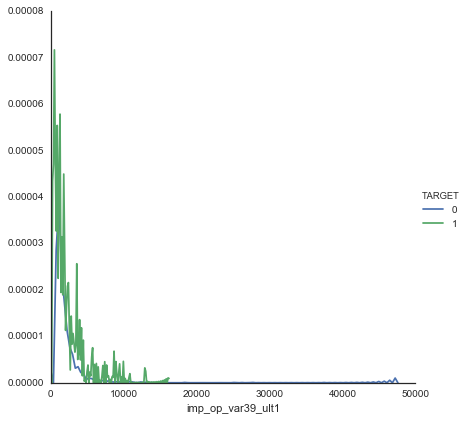

In [17]:
sns.FacetGrid(santrainder, hue='TARGET', size=6).map(sns.kdeplot, 'imp_op_var39_ult1').add_legend()

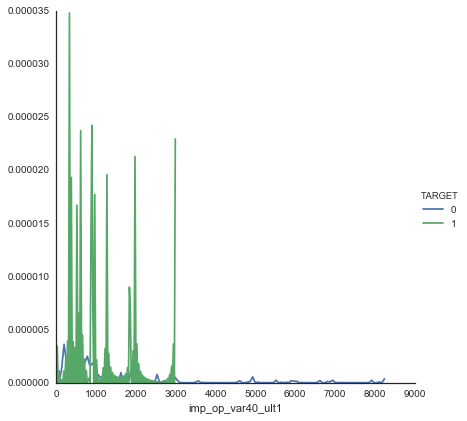

In [18]:
sns.FacetGrid(santrainder, hue='TARGET', size=6).map(sns.kdeplot, 'imp_op_var40_ult1').add_legend()

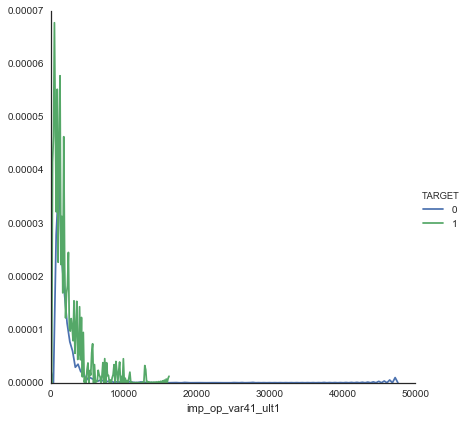

In [19]:
sns.FacetGrid(santrainder, hue='TARGET', size=6).map(sns.kdeplot, 'imp_op_var41_ult1').add_legend()

### ind_varX (indicator)
There are 67 total features that are '**indicator**' features with dummy values of either 0 or 1:

In [20]:
print santrainder.columns[20:87]
print santrainder['ind_var1_0'].value_counts() # example
print santrainder['ind_var1'].value_counts() # example

Index([u'ind_var1_0', u'ind_var1', u'ind_var5_0', u'ind_var5', u'ind_var6_0',
       u'ind_var6', u'ind_var8_0', u'ind_var8', u'ind_var12_0', u'ind_var12',
       u'ind_var13_0', u'ind_var13_corto_0', u'ind_var13_corto',
       u'ind_var13_largo_0', u'ind_var13_largo', u'ind_var13_medio_0',
       u'ind_var13', u'ind_var14_0', u'ind_var14', u'ind_var17_0',
       u'ind_var17', u'ind_var18_0', u'ind_var19', u'ind_var20_0',
       u'ind_var20', u'ind_var24_0', u'ind_var24', u'ind_var25_cte',
       u'ind_var26_0', u'ind_var26_cte', u'ind_var25', u'ind_var30_0',
       u'ind_var30', u'ind_var31_0', u'ind_var31', u'ind_var32_cte',
       u'ind_var32', u'ind_var33_0', u'ind_var33', u'ind_var34',
       u'ind_var37_cte', u'ind_var37', u'ind_var39_0', u'ind_var40_0',
       u'ind_var41_0', u'ind_var39', u'ind_var44_0', u'ind_var44',
       u'num_var1_0', u'num_var1', u'num_var4', u'num_var5_0', u'num_var5',
       u'num_var8_0', u'num_var8', u'num_var12_0', u'num_var12',
       u'num_var13_0'

And from these indicator features we can see that they often come in pairs of **ind_varX** and **ind_varX_0**. It's speculated that each of these indicator varXs is some sort of banking feature, service, or product, and the suffix **0** suggests an explicit opt-out of the product (vs. simply not having used the product before)

### num_varX (number)
There a lot of these.
Yada yada, might be number of products, I need to look at these some more.
Some might actually be tallies of the indicator features, which would be a lot simpler to deal with than the indicator features themselves.

### saldo_varX (balance)
There are 25 features that are formatted as saldo_varX.

In [21]:
print santrainder.columns[128:153]

Index([u'saldo_var1', u'saldo_var5', u'saldo_var6', u'saldo_var8',
       u'saldo_var12', u'saldo_var13_corto', u'saldo_var13_largo',
       u'saldo_var13_medio', u'saldo_var13', u'saldo_var14', u'saldo_var17',
       u'saldo_var18', u'saldo_var20', u'saldo_var24', u'saldo_var26',
       u'saldo_var25', u'saldo_var30', u'saldo_var31', u'saldo_var32',
       u'saldo_var33', u'saldo_var34', u'saldo_var37', u'saldo_var40',
       u'saldo_var42', u'saldo_var44'],
      dtype='object')


Wherever applicable, saldo_varX_corto + saldo_varX_medio + saldo_varX_largo = saldo_varX. There are some commonalities between varXs (somewhat similar to how imp_op features seemed to be).

But most of the data here are zeroes, but saldo_varX features that *aren't* mostly zeroes are saldo_var5, saldo_var30, saldo_42. According to the figures below, unhappy customers had smaller and lower range of these values, while happy customers had a much greater and higher range of these values.

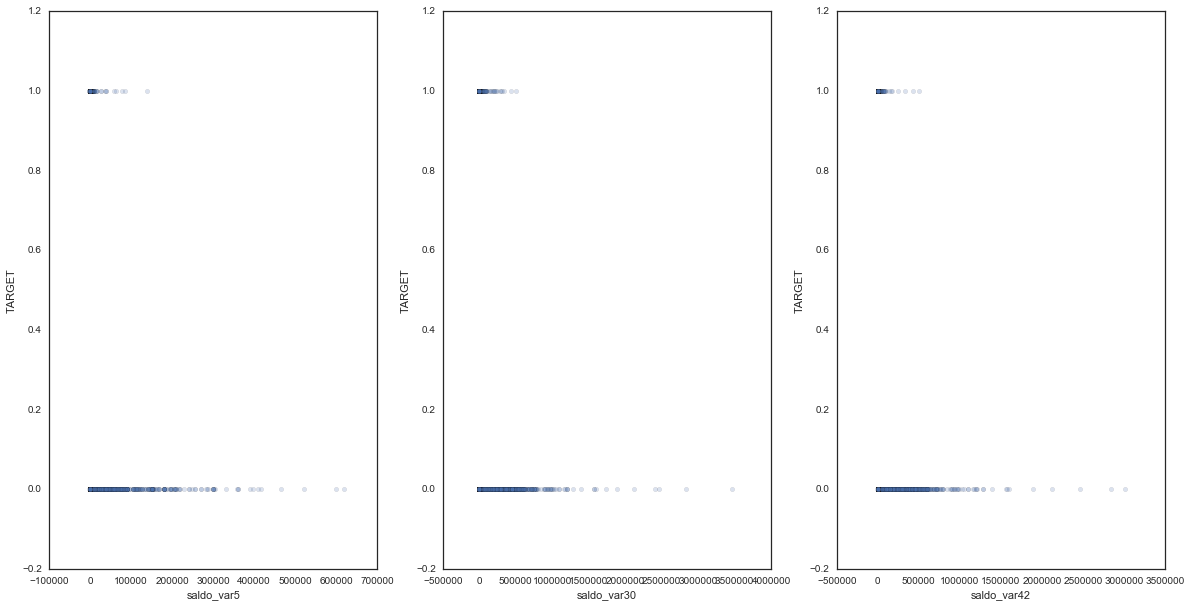

In [22]:
#sns.FacetGrid(santrainder, hue='TARGET', size=6).map(sns.kdeplot, 'saldo_var5').add_legend()
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.scatter(santrainder.saldo_var5, santrainder.TARGET, alpha=0.2)
plt.xlabel('saldo_var5')
plt.ylabel('TARGET')
plt.subplot(132)
plt.scatter(santrainder.saldo_var30, santrainder.TARGET, alpha=0.2)
plt.xlabel('saldo_var30')
plt.ylabel('TARGET')
plt.subplot(133)
plt.scatter(santrainder.saldo_var42, santrainder.TARGET, alpha=0.2)
plt.xlabel('saldo_var42')
plt.ylabel('TARGET')

### delta
"Delta" itself may be a [finance term](http://www.investopedia.com/terms/d/delta.asp) meaning "the ratio comparing the change in the price of the underlying asset to the corresponding change in the price of a derivative. Sometimes referred to as the 'hedge ratio.'"

My jury's still out on that in this context, because all the delta features here are at least 97.30%-99.99% zeroes each with sparsely any other value making up the rest.

In [69]:
for x in range(154, 173, 1):
    print santrainder.iloc[:, x].value_counts()

0             76018
9999999999        2
Name: delta_imp_amort_var18_1y3, dtype: int64
0             76018
9999999999        2
Name: delta_imp_amort_var34_1y3, dtype: int64
 0.000000e+00    73948
-1.000000e+00     1675
 1.000000e+10      370
-5.000000e-01        2
 4.000000e+00        2
-3.333333e-01        2
-4.995000e-01        1
-2.910826e-01        1
 1.000000e+00        1
 2.333092e+00        1
-8.333333e-01        1
 1.181818e+00        1
-8.000000e-01        1
 1.222222e+00        1
 1.777778e+00        1
 4.000000e-01        1
-1.000000e-01        1
 1.538462e-01        1
-9.038462e-01        1
-3.494898e-01        1
-9.090909e-02        1
 5.500000e+00        1
 1.605039e-01        1
-1.973684e-01        1
-6.666667e-01        1
-7.602877e-01        1
 1.445714e+00        1
Name: delta_imp_aport_var13_1y3, dtype: int64
 0.000000e+00    75960
 1.000000e+10       39
-1.000000e+00       17
 6.853333e-01        1
 1.000055e+00        1
 1.500000e+00        1
-7.500000e-01        1


### varX (just varX, plain and simply)
No prefix, no suffix, no other descriptors, they are **var3, var15, var21, var36, and var38**. Most of which are contextually more interesting than the rest, I like to think, probably because they're less daunting somehow.

var3 is nationality, var 15 is age, var36 is still up in the air, and var38 is possibly mortgage value

#### var3 is nationality
I don't actually understand why var3 is nationality, but it seems to be accepted in the forums. One user [commented](https://www.kaggle.com/c/santander-customer-satisfaction/forums/t/19367/var3/111169#post111169) that the distribution of categories/countries matches what they expect from a bank of this caliber. Each category from 1 to 238 represents a different country, with country 2 having the most customers represented in this data set.

In [111]:
print santrainder.var3.describe()
santrainder.var3.value_counts()[0:20]

count     76020.000000
mean      -1523.199277
std       39033.462364
min     -999999.000000
25%           2.000000
50%           2.000000
75%           2.000000
max         238.000000
Name: var3, dtype: float64


 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
 6            82
 0            75
 10           72
 11           66
 5            63
 14           61
 15           34
 18           10
 16            9
 17            7
Name: var3, dtype: int64

var3 is entirely positive (as categorical variables are wont to be) save for the one hundred seventeen -999999s. These clearly represent errors or unknowns. We can either remove these entries or replace them with the mode and remember to do the same with the test data.

In [112]:
# var3 error -999999, 117 of them
# 117/77060 = 0.0015 (not even 1% of the entries)
# drop as null or replace with mode (category 2)?
santrainder = santrainder.replace(-999999,2) 

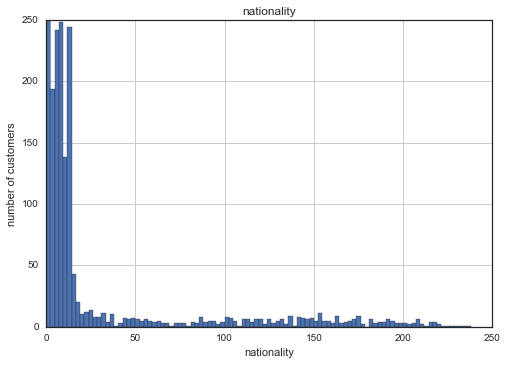

In [113]:
# distribution
santrainder.var3.hist(bins=100)
plt.xlabel('nationality')
plt.ylabel('number of customers')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,250)) # country 2 is off the charts with this range
plt.title('nationality')
plt.show()

#### var15 is age
The histogram of var15 is pretty obviously age. Some kids have bank accounts apparently (it's possible!), and the spike for the 20-25 range coincides with [Santander having had a campaign targeted at university students](https://www.kaggle.com/c/santander-customer-satisfaction/forums/t/19291/data-dictionary/110414#post110414) some time ago.

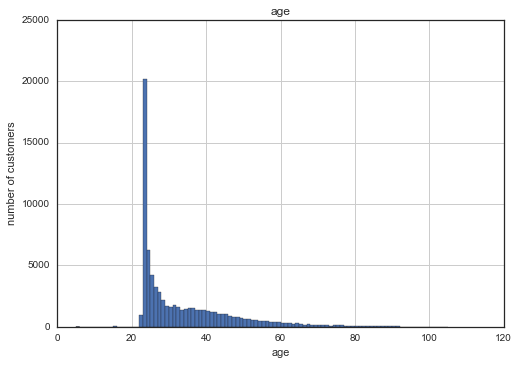

In [114]:
# age distribution
santrainder.var15.hist(bins=100)
plt.xlabel('age')
plt.ylabel('number of customers')
plt.title('age')
plt.show()

#### var21 is weird
like, i don't even

In [133]:
santrainder.var21.value_counts()

0        75152
900        236
1800       206
4500        96
3000        84
7200        62
3600        52
1500        31
6000        27
2700        26
9000        14
1200        12
5400         4
2400         3
18000        2
3300         2
4200         2
5100         2
2100         2
7500         1
6600         1
5700         1
10500        1
30000        1
Name: var21, dtype: int64

#### var38 is either total asset worth or mortgage value
The **mean of var38** is 117235.81, and [Spain's average mortgage was 118000 euros in 2011 and was 105000 in 2015.](https://www.kaggle.com/c/santander-customer-satisfaction/forums/t/19895/var38-is-mortgage-value)
[Insert elaboration here. Looking for actual resources to back this up or disprove it but low priority as knowing isn't necessarily... necessary for modeling.]

In [115]:
# total asset worth or mortgage value
santrainder.var38.describe()

count    7.602000e+04
mean     1.172358e+05
std      1.826646e+05
min      5.163750e+03
25%      6.787061e+04
50%      1.064092e+05
75%      1.187563e+05
max      2.203474e+07
Name: var38, dtype: float64

var38 also has a terrible distribution to look at, since there's a wide range of magnitude orders under this feature. Log scaling makes it easier on the eyes.

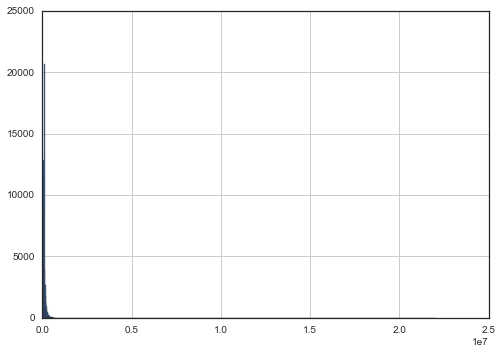

In [116]:
# histogram of original var38
santrainder.var38.hist(bins=1000);

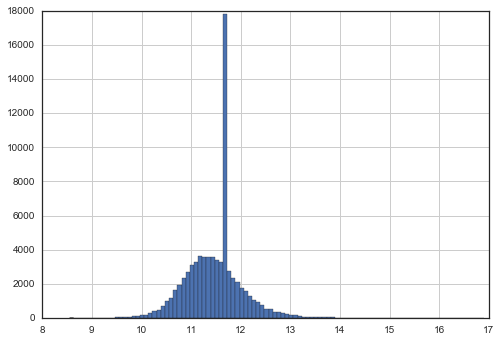

In [117]:
# wide range of magnitude orders => log scaling
santrainder['var38_log'] = santrainder['var38'].map(np.log)
santrainder.var38_log.hist(bins=100)

In [118]:
# What is that stark spike there?
print np.exp(santrainder.var38_log.mode())
print santrainder.var38.mode()

0    117310.979016
dtype: float64
0    117310.979016
dtype: float64


In [119]:
santrainder.var38.value_counts().nlargest(5)

117310.979016    14868
451931.220000       16
463625.160000       12
288997.440000       11
104563.800000       11
Name: var38, dtype: int64

There... there are a lot of observations that has a specific value of 117310.979016 in this feature. How do we deal with this?
Without the spike there the log of var38 is a normal distribution.

### creating features
#### number of zeroes per observation
There are a *lot* of zeroes. Maybe that's significant.

In [120]:
santrainder['zeroes'] = np.sum(santrainder.loc[:, 'imp_ent_var16_ult1':'var38']==0, axis=1) # count the number of bools, value == 0 is True
santrainder['zeroes'].head()

0    292
1    266
2    277
3    248
4    256
Name: zeroes, dtype: int64

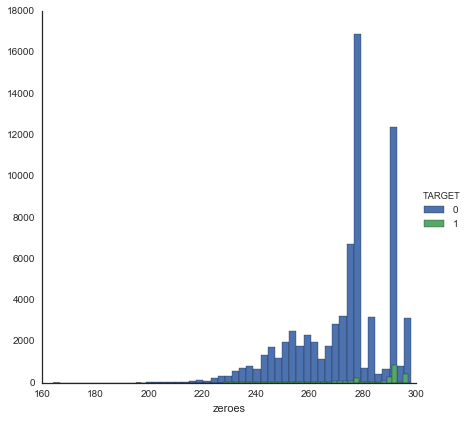

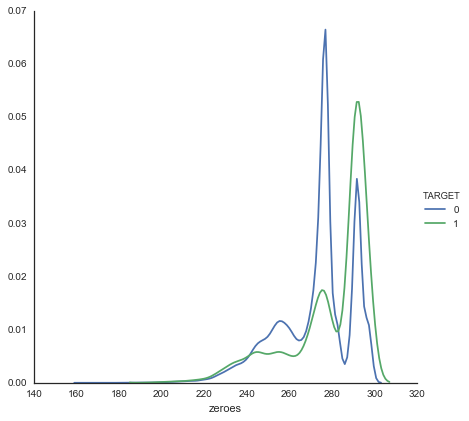

In [158]:
sns.FacetGrid(santrainder, hue='TARGET', size=6).map(plt.hist, 'zeroes', bins=50).add_legend()
sns.FacetGrid(santrainder, hue='TARGET', size=6).map(sns.kdeplot, 'zeroes').add_legend()

## 7. Feature Selection
Something something I'm still working on this sorry.

Some graphical observations:

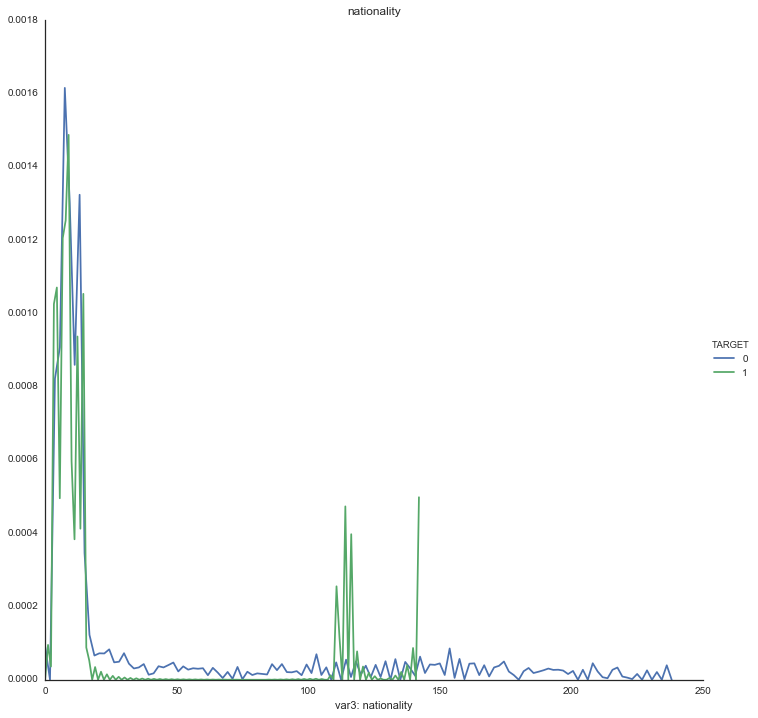

In [122]:
# var3 kernel density estimation (probability density function) because histogram is weird
sns.FacetGrid(santrainder, hue='TARGET', size=10).map(sns.kdeplot, 'var3').add_legend()
plt.title('nationality');
plt.xlabel('var3: nationality');
# There might be something to living in a country in the category 110-140 range.

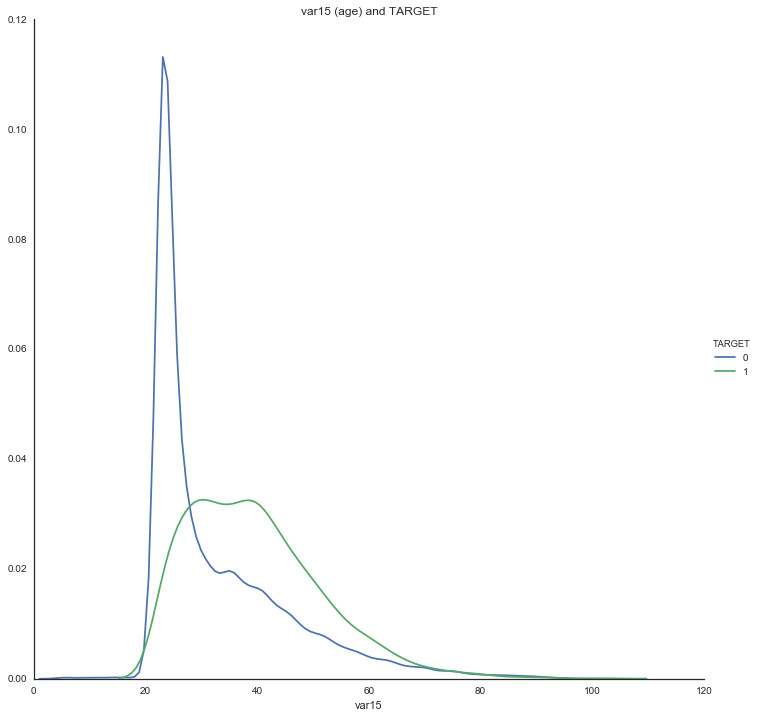

In [123]:
# var15 (age), kernel density estimate plot because it's also easier to read than a histogram
sns.FacetGrid(santrainder, hue='TARGET', size=10).map(sns.kdeplot, "var15").add_legend()
plt.title('var15 (age) and TARGET');

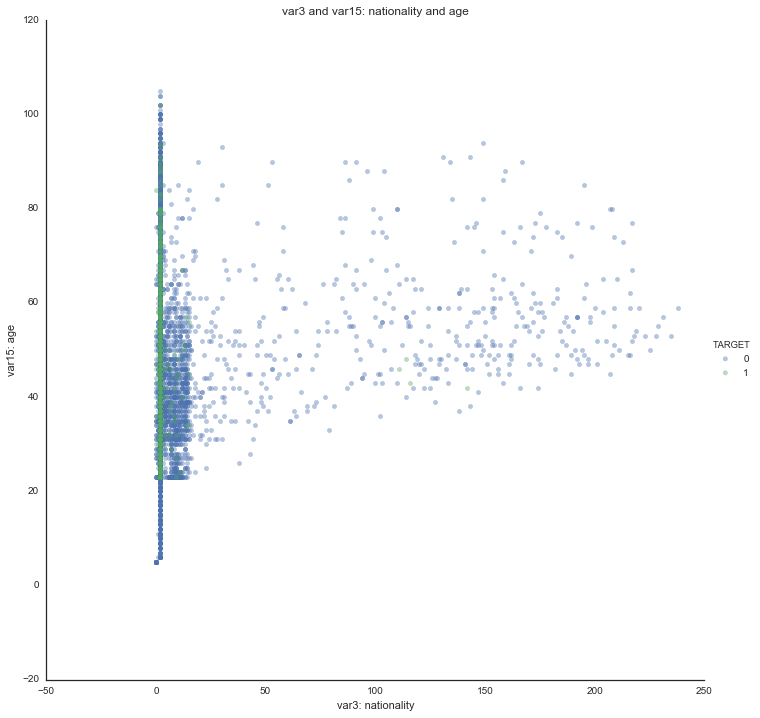

In [124]:
sns.FacetGrid(santrainder, hue='TARGET', size=10).map(plt.scatter, 'var3', 'var15', alpha = 0.4).add_legend()
plt.title('var3 and var15: nationality and age');
plt.xlabel('var3: nationality');
plt.ylabel('var15: age');

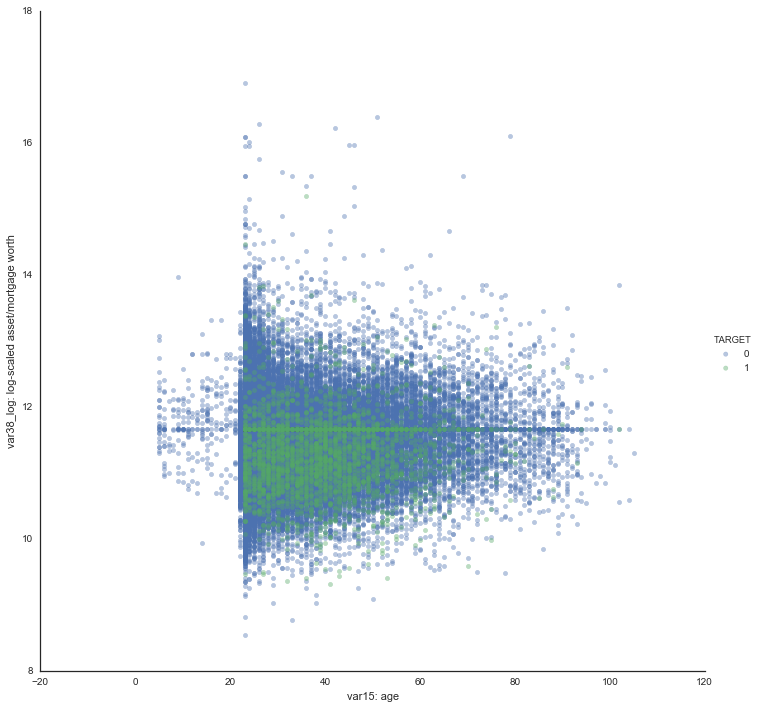

In [125]:
sns.FacetGrid(santrainder, hue='TARGET', size=10).map(plt.scatter, 'var15', 'var38_log', alpha=0.4).add_legend()
plt.xlabel('var15: age');
plt.ylabel('var38_log: log-scaled asset/mortgage worth');

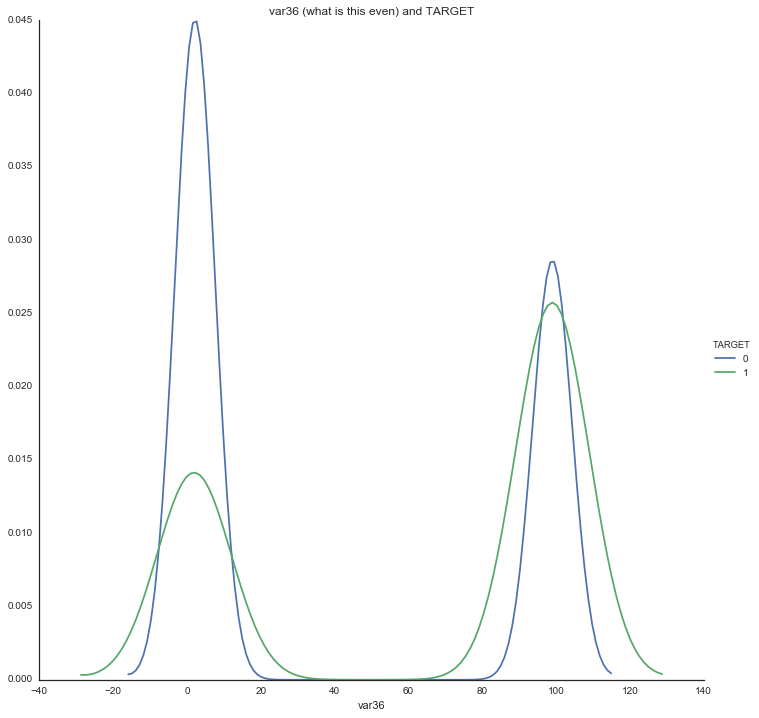

In [126]:
# I don't know what var36 is other than it's probably categorical
# but there is some sort of relationship with TARGET
sns.FacetGrid(santrainder, hue='TARGET', size=10).map(sns.kdeplot, 'var36').add_legend()
plt.title('var36 (what is this even) and TARGET');

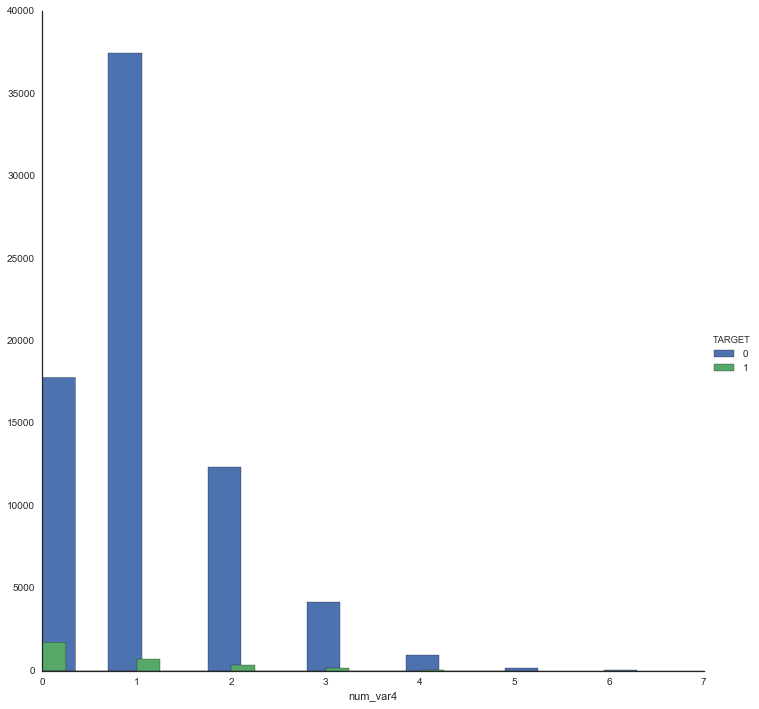

In [127]:
sns.FacetGrid(santrainder, hue='TARGET', size=10).map(plt.hist, 'num_var4', bins=20).add_legend()

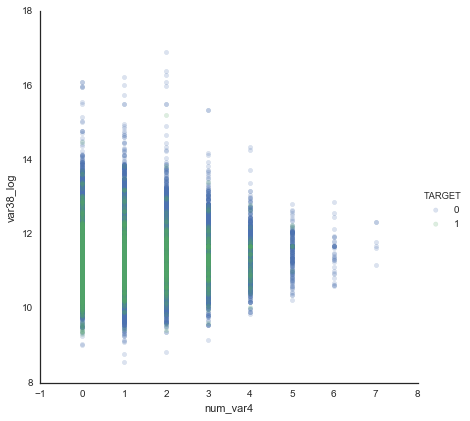

In [39]:
sns.FacetGrid(santrainder, hue='TARGET', size=10).map(plt.scatter, 'num_var4', 'var38_log', alpha = 0.2).add_legend()

## 6. Modeling
The response is a binary output, so it stands to reason that **logistic regression** is the most appropriate estimator to use.

In [ ]:
feature_cols = []
X = santrainder[feature_cols]
y = 

## 7. Concluding Thoughts